In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from spacy.symbols import amod
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
import string
import spacy
import re

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
twitter_df = pd.read_csv('../data/sentiment_tweets3.csv')
twitter_df.rename(columns = {'message to examine': 'text', 'label (depression result)': 'target'}, inplace = True)

In [4]:
twitter_df['depressed'] = np.where(twitter_df['target'] == 1, 'positive', 'negative')

In [5]:
twitter_df.depressed.value_counts(normalize=True)

negative    0.775645
positive    0.224355
Name: depressed, dtype: float64

In [6]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

In [7]:
# remove hyperlinks in text
twitter_df['text_without_links'] = twitter_df.text.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'@\S+', '', regex=True).str.strip()

In [8]:
twitter_df['text_clean'] = twitter_df.text_without_links.map(punc_lower)
twitter_df

,Index,text,target,depressed,text_without_links,text_clean
0,106,just had a real good moment. i missssssssss hi...,0,negative,just had a real good moment. i missssssssss hi...,just had a real good moment i missssssssss hi...
1,217,is reading manga http://plurk.com/p/mzp1e,0,negative,is reading manga,is reading manga
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0,negative,-,
3,288,@lapcat Need to send 'em to my accountant tomo...,0,negative,Need to send 'em to my accountant tomorrow. Od...,need to send em to my accountant tomorrow od...
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,negative,ADD ME ON MYSPACE!!! myspace.com/LookThunder,add me on myspace myspace com lookthunder
...,...,...,...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1,positive,No Depression by G Herbo is my mood from now o...,no depression by g herbo is my mood from now o...
10310,802310,What do you do when depression succumbs the br...,1,positive,What do you do when depression succumbs the br...,what do you do when depression succumbs the br...
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1,positive,Ketamine Nasal Spray Shows Promise Against Dep...,ketamine nasal spray shows promise against dep...
10312,802312,dont mistake a bad day with depression! everyo...,1,positive,dont mistake a bad day with depression! everyo...,dont mistake a bad day with depression everyo...


In [9]:
twitter_df = twitter_df[twitter_df.text_clean != ' ']
twitter_df

,Index,text,target,depressed,text_without_links,text_clean
0,106,just had a real good moment. i missssssssss hi...,0,negative,just had a real good moment. i missssssssss hi...,just had a real good moment i missssssssss hi...
1,217,is reading manga http://plurk.com/p/mzp1e,0,negative,is reading manga,is reading manga
3,288,@lapcat Need to send 'em to my accountant tomo...,0,negative,Need to send 'em to my accountant tomorrow. Od...,need to send em to my accountant tomorrow od...
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,negative,ADD ME ON MYSPACE!!! myspace.com/LookThunder,add me on myspace myspace com lookthunder
5,624,so sleepy. good times tonight though,0,negative,so sleepy. good times tonight though,so sleepy good times tonight though
...,...,...,...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1,positive,No Depression by G Herbo is my mood from now o...,no depression by g herbo is my mood from now o...
10310,802310,What do you do when depression succumbs the br...,1,positive,What do you do when depression succumbs the br...,what do you do when depression succumbs the br...
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1,positive,Ketamine Nasal Spray Shows Promise Against Dep...,ketamine nasal spray shows promise against dep...
10312,802312,dont mistake a bad day with depression! everyo...,1,positive,dont mistake a bad day with depression! everyo...,dont mistake a bad day with depression everyo...


In [10]:
# Split the data into X and y data sets
X = twitter_df.text_clean
y = twitter_df.depressed

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
def vectorize_text(model, X_train, X_test, min_df=0.003, binary=False, ):
    if binary:
        cv = model(stop_words = 'english', min_df = min_df, ngram_range = (1,2), binary=True)
    else:
        cv = model(stop_words = 'english', min_df = min_df)

    X_train_vectorized = cv.fit_transform(X_train)
    X_test_vectorized  = cv.transform(X_test)

    pd.DataFrame(X_train_vectorized.toarray(), columns=cv.get_feature_names()).head()

    return X_train_vectorized, X_test_vectorized

In [12]:
def log_reg(X_train_cv, y_train, X_test_cv):
    lr = LogisticRegression()

    # Train the first model
    lr.fit(X_train_cv, y_train)

    return lr.predict(X_test_cv)

In [13]:
def naive_bayes(model, X_train_cv, y_train, X_test_cv):
    model.fit(X_train_cv, y_train)
    return model.predict(X_test_cv)

In [14]:
# Create a function to calculate the error metrics, since we'll be doing this several times
def conf_matrix(actual, predicted):
    plt.figure(1, figsize=(10, 8))
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':28}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg), 3)
    precision = round((true_pos) / (true_pos + false_pos), 3)
    recall = round((true_pos) / (true_pos + false_neg), 3)
    f1 = round(2 * (precision * recall) / (precision + recall), 3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [15]:
# Compile all of the error metrics into a dataframe for comparison
def results_df(columns, *args):
    return pd.DataFrame(list(zip(*args)), columns = columns).set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])

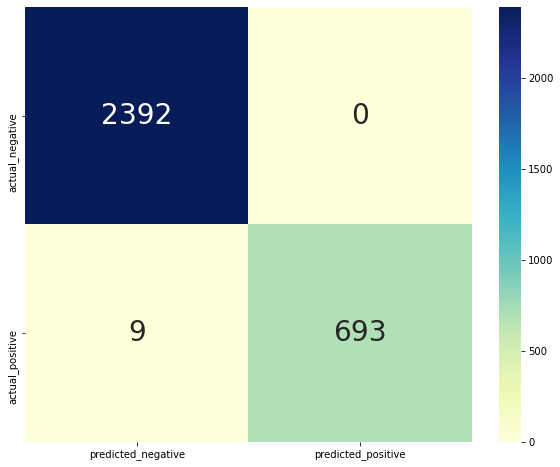

In [16]:
# The heat map for the first logistic regression model
X_train_cv1, X_test_cv1 = vectorize_text(CountVectorizer, X_train, X_test, 0.003) 
y_pred_cv1 = log_reg(X_train_cv1, y_train, X_test_cv1)
cm1 = conf_matrix(y_test, y_pred_cv1)

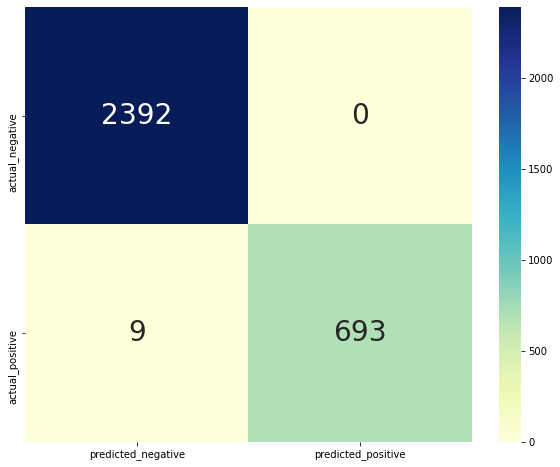

In [17]:
# The heat map for the first logistic regression model
X_train_cv2, X_test_cv2 = vectorize_text(CountVectorizer, X_train, X_test, 0.003, True) 
y_pred_cv2 = log_reg(X_train_cv2, y_train, X_test_cv2)
cm2 = conf_matrix(y_test, y_pred_cv2)

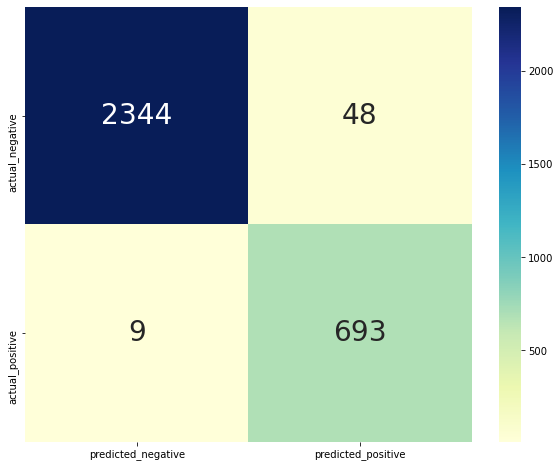

In [18]:
# Here's the heat map for the first Naive Bayes model
y_pred_cv1_nb = naive_bayes(MultinomialNB(), X_train_cv1, y_train, X_test_cv1)
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

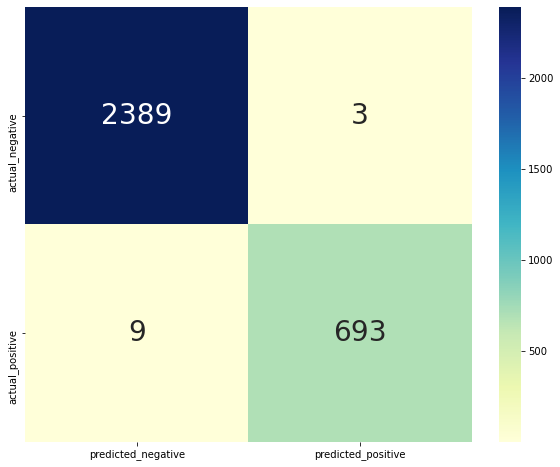

In [19]:
# Here's the heat map for the second Naive Bayes model
y_pred_cv2_nb = naive_bayes(BernoulliNB(), X_train_cv2, y_train, X_test_cv2)
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

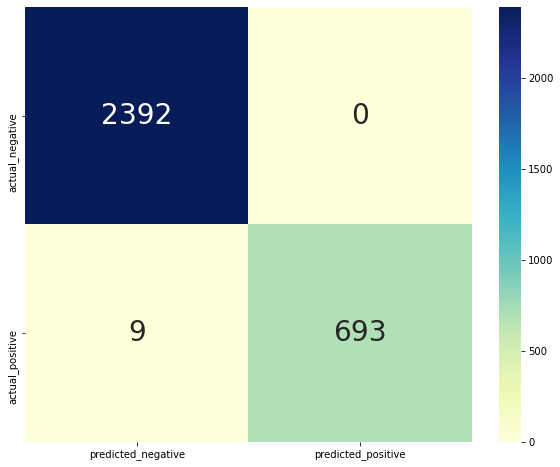

In [20]:
# Fit the first logistic regression on the TF-IDF data
X_train_tfidf1, X_test_tfidf1 = vectorize_text(CountVectorizer, X_train, X_test, 0.003) 
y_pred_tfidf1_lr = log_reg(X_train_tfidf1, y_train, X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

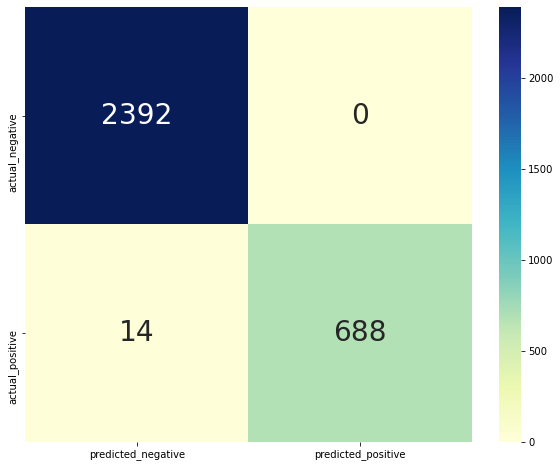

In [21]:
# Fit the second logistic regression on the TF-IDF data
X_train_tfidf2, X_test_tfidf2 = vectorize_text(TfidfVectorizer, X_train, X_test, 0.003, True)
y_pred_tfidf2_lr = log_reg(X_train_tfidf2, y_train, X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

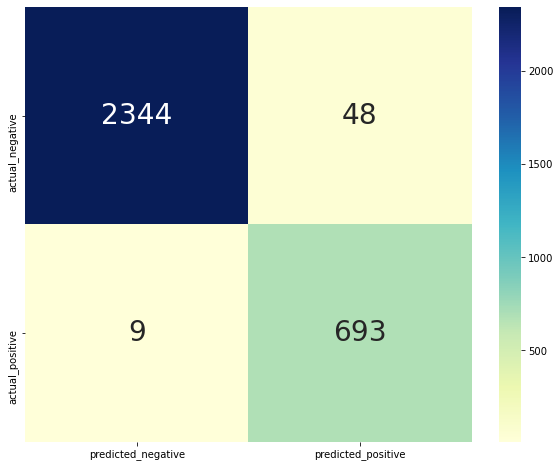

In [22]:
# Fit the first Naive Bayes model on the TF-IDF data
y_pred_tfidf1_nb = naive_bayes(MultinomialNB(), X_train_tfidf1.toarray(), y_train, X_test_tfidf1)
cm7 = conf_matrix(y_test, y_pred_tfidf1_nb)

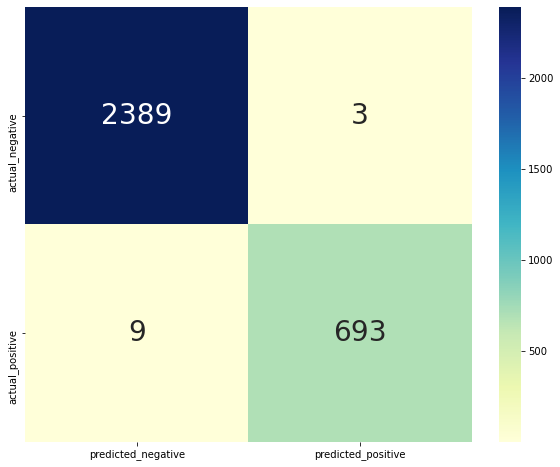

In [23]:
# Fit the second Naive Bayes model on the TF-IDF data
y_pred_tfidf2_nb = naive_bayes(BernoulliNB(), X_train_tfidf2.toarray(), y_train, X_test_tfidf2)
cm8 = conf_matrix(y_test, y_pred_tfidf2_nb)

In [24]:
results_df(['LogReg1','LogReg2', 'NB1', 'NB2', 'LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF'], cm1, cm2, cm3, cm4, cm5, cm6, cm7, cm8)

,LogReg1,LogReg2,NB1,NB2,LR1-TFIDF,LR2-TFIDF,NB1-TFIDF,NB2-TFIDF
Accuracy,0.997,0.997,0.982,0.996,0.997,0.995,0.982,0.996
Precision,1.000,1.000,0.935,0.996,1.000,1.000,0.935,0.996
Recall,0.987,0.987,0.987,0.987,0.987,0.980,0.987,0.987
F1 Score,0.993,0.993,0.960,0.991,0.993,0.990,0.960,0.991


In [25]:
twitter_df['spacy_doc'] = list(nlp.pipe(twitter_df.text_clean))

<ipython-input-25-edde23ed366c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['spacy_doc'] = list(nlp.pipe(twitter_df.text_clean))


In [26]:
def pos_by_sentiment(df, target):
    is_positive = df[df[target]==1]
    is_negative = df[df[target]==0]

    pos_adj = [token.text.lower() for doc in is_positive.spacy_doc for token in doc if token.pos_=='ADJ']
    neg_adj = [token.text.lower() for doc in is_negative.spacy_doc for token in doc if token.pos_=='ADJ']

    pos_noun = [token.text.lower() for doc in is_positive.spacy_doc for token in doc if token.pos_=='NOUN']
    neg_noun = [token.text.lower() for doc in is_negative.spacy_doc for token in doc if token.pos_=='NOUN']

    return is_positive, is_negative, pos_adj, neg_adj, pos_noun, neg_noun

In [27]:
# Counter(pos_adj).most_common(10)
# Counter(neg_adj).most_common(10)
# Counter(pos_noun).most_common(10)
# # Counter(neg_noun).most_common(10)

In [28]:
def get_amods(noun, ser):
    amod_list = []
    for doc in ser:
        for token in doc:
            if (token.text) == noun:
                for child in token.children:
                    if child.dep == amod:
                        amod_list.append(child.text.lower())
    return sorted(amod_list)

In [29]:
def amods_by_sentiment(noun):
    print(f"Adjectives describing {str.upper(noun)}:\n")
    
    print("POSITIVE:")
    pprint(get_amods(noun, is_positive.spacy_doc))
    
    print("\nNEGATIVE:")
    pprint(get_amods(noun, is_negative.spacy_doc))

In [30]:
def wordcloud_plot(word_list, background_color = 'black'):
    words = ' '.join(word_list)

    wordcloud_words = " ".join([word for word in words.split() if 'http' not in word and not word.startswith('@') and not word.startswith('#') and word != 'RT'])

    wordcloud = WordCloud(stopwords=STOPWORDS, background_color=background_color, width=2048, height=2048).generate(wordcloud_words)

    plt.figure(1, figsize=(16, 16))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [31]:
is_positive, is_negative, pos_adj, neg_adj, pos_noun, neg_noun = pos_by_sentiment(twitter_df, 'target')
# print(spacy_tokens(twitter_df, 'depressed'))

In [32]:
# amods_by_sentiment("depression")

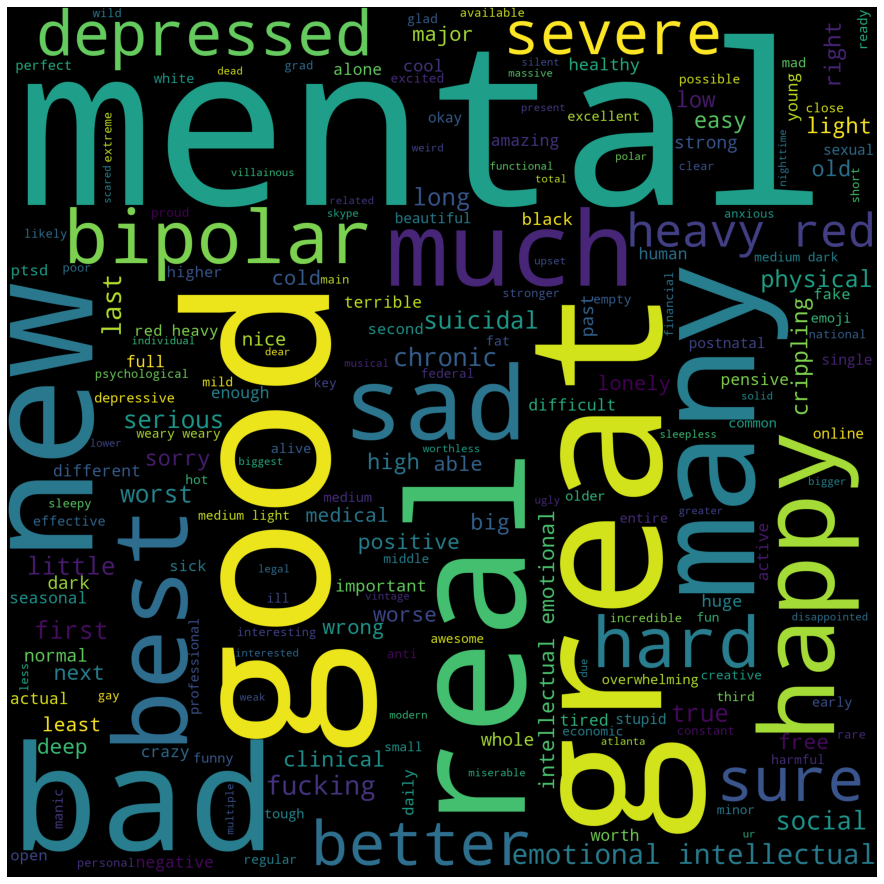

In [33]:
wordcloud_plot(pos_adj)

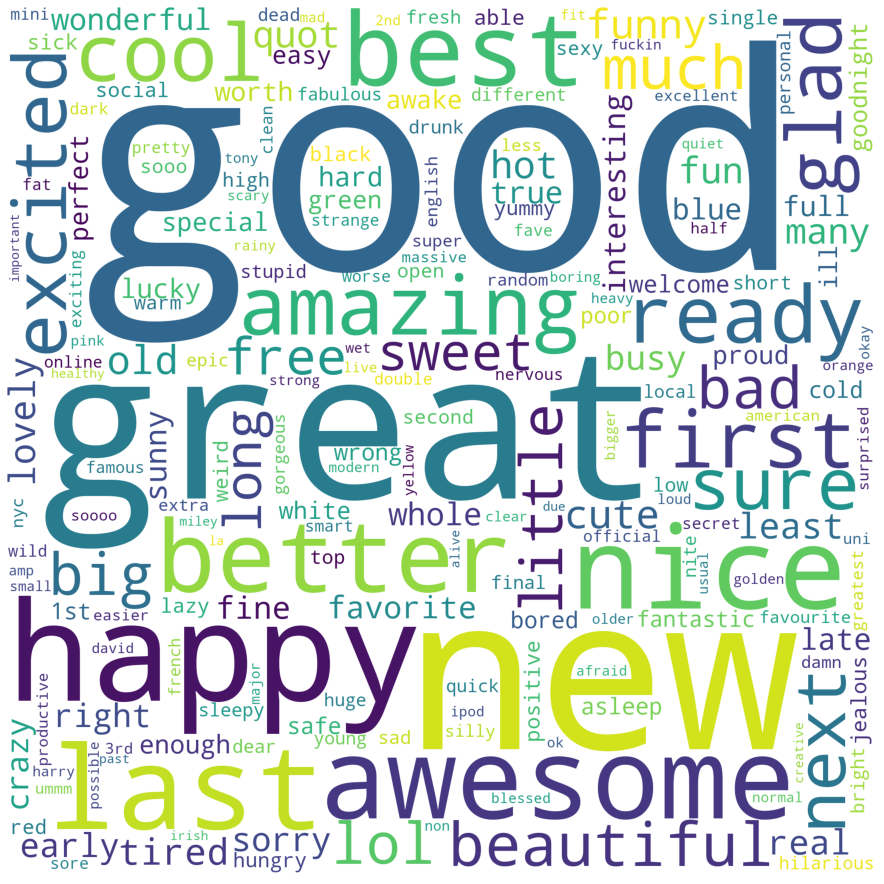

In [34]:
wordcloud_plot(neg_adj, 'white')

In [35]:
corpus = twitter_df['text_without_links'].fillna(value='')

In [36]:
for tweet in twitter_df['text'].sample(10).values:
    print(tweet)
    print()

Roger Federer's jump to victory!  http://tinyurl.com/l8jrt4

@trinafraser Impaired is impaired & I'm feeling second class to workers that have been driving to work forced on pill cocktails causing depression to go down a couple of lunch beers like Prince or Elvis. Pros need a chemistry set & bigger budgets looking for evidence of impairment in 2018?

@bethanydillon I would like to have lunch with you again 

depression and anxiety are two whole ass bitches that i refuse to let fw me today.

your future place is jahannam if you make fun of someone's depression for just fucking stupid fanwar

What happened to that week? Time to amble down to The Phoenix  #fb

Good morning! 

Mars Planets are like Revels without all the poor options like coffee and bizarre orange substitute 

17 Again was the best movie ever!I think everyone should do themselves justice and go and see it.For me...  

OMG 900 followers!!!!!! 



In [37]:
stop_words = ENGLISH_STOP_WORDS.union(['math'])

In [38]:
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=0.003, max_df=0.75)

tweet_word_matrix = tfidf.fit_transform(corpus)

vocab = tfidf.get_feature_names()

## NMF

In [39]:
nmf = NMF(n_components=5)

nmf.fit(tweet_word_matrix)

/home/aaron/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=5)

#### Tweet/Topic Matrix

In [40]:
twitter_df

,Index,text,target,depressed,text_without_links,text_clean,spacy_doc
0,106,just had a real good moment. i missssssssss hi...,0,negative,just had a real good moment. i missssssssss hi...,just had a real good moment i missssssssss hi...,"(just, had, a, real, good, moment, , i, misss..."
1,217,is reading manga http://plurk.com/p/mzp1e,0,negative,is reading manga,is reading manga,"(is, reading, manga)"
3,288,@lapcat Need to send 'em to my accountant tomo...,0,negative,Need to send 'em to my accountant tomorrow. Od...,need to send em to my accountant tomorrow od...,"(need, to, send, , em, to, my, accountant, to..."
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,negative,ADD ME ON MYSPACE!!! myspace.com/LookThunder,add me on myspace myspace com lookthunder,"(add, me, on, myspace, , myspace, com, loo..."
5,624,so sleepy. good times tonight though,0,negative,so sleepy. good times tonight though,so sleepy good times tonight though,"(so, sleepy, , good, times, tonight, though)"
...,...,...,...,...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1,positive,No Depression by G Herbo is my mood from now o...,no depression by g herbo is my mood from now o...,"(no, depression, by, g, herbo, is, my, mood, f..."
10310,802310,What do you do when depression succumbs the br...,1,positive,What do you do when depression succumbs the br...,what do you do when depression succumbs the br...,"(what, do, you, do, when, depression, succumbs..."
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1,positive,Ketamine Nasal Spray Shows Promise Against Dep...,ketamine nasal spray shows promise against dep...,"(ketamine, nasal, spray, shows, promise, again..."
10312,802312,dont mistake a bad day with depression! everyo...,1,positive,dont mistake a bad day with depression! everyo...,dont mistake a bad day with depression everyo...,"(do, nt, mistake, a, bad, day, with, depressio..."


In [41]:
tweet_topic_matrix = nmf.transform(tweet_word_matrix)

In [42]:
tweet_topic_matrix_df = pd.DataFrame(tweet_topic_matrix).add_prefix('topic_')

In [43]:
tweet_topic_matrix_df[['raw_tweets', 'clean_tweets']] = twitter_df[['text', 'text_without_links']]
tweet_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,raw_tweets,clean_tweets
0,0.000235,0.058908,0.000000,0.000000,0.092214,just had a real good moment. i missssssssss hi...,just had a real good moment. i missssssssss hi...
1,0.000168,0.001123,0.000713,0.000528,0.000765,is reading manga http://plurk.com/p/mzp1e,is reading manga
2,0.000919,0.012053,0.000000,0.000000,0.006171,NaN,NaN
3,0.000000,0.000000,0.000320,0.083514,0.000369,@lapcat Need to send 'em to my accountant tomo...,Need to send 'em to my accountant tomorrow. Od...
4,0.000000,0.000000,0.000000,0.000000,0.086673,ADD ME ON MYSPACE!!! myspace.com/LookThunder,ADD ME ON MYSPACE!!! myspace.com/LookThunder


#### Word/Topic Matrix

In [44]:
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=vocab).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4
10,0.014621,0.054133,0.003786,0.001900,0.010857
100,0.017984,0.014677,0.000000,0.004152,0.041861
12,0.010602,0.017100,0.000000,0.016758,0.001756
20,0.044370,0.009817,0.000000,0.016818,0.027725
30,0.013289,0.034733,0.000000,0.001602,0.018725


## Topic Interpretation


In [78]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(20)['clean_tweets'].values:
    print(tweet,'\n')

its my best friends birthdayyy!!!!! 

I love my hubster...he is the best 

2 weeks&amp;5 days until i see my oldest sister. and go to new york AND THOUSAND ISLANDS.  i cannot wait !!!! 

night! I am right behind ya 

In 24hrs time I will be at uni waiting to start my 1st exam, scary. I am working hard this morning though, and feeling ok about it atm 

Thanks! I will!  hopefully we'll get a chance to bring then down soon. 

talk to you when I get back k?  hugs. At pedder red now. Beams. 

well my knee should be healed by next week 

Where did everyone go? =| I NEED SOME CHEERING UP, DAMNIT! 

a better man than I.  Up early and then back to bed 

ok so I'm leaving early today  4:15 makes up for coming in early I guess :-D #fb 

Oh Good, i was hoping to get some positive review from someone who watched it 

Nothin' like a good book and some spring cleaning. 

???, ???????? 30?? ??????? ? Subway.???-??? 

about to go to sleep. 

Mars Planets are like Revels without all the poor options lik

In [77]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(20)

,topic_0,topic_1,topic_2,topic_3,topic_4
thanks,0.000000,0.000000,3.456388,0.000000,0.000000
haha,0.000000,0.382850,0.232213,0.000000,0.000000
follow,0.000000,0.059309,0.149017,0.081804,0.000000
great,0.079328,0.179471,0.112147,0.024616,0.314090
guys,0.000000,0.131702,0.109924,0.026446,0.036742
today,0.021981,0.250546,0.091001,0.000000,0.514220
hey,0.000000,0.210559,0.085837,0.029842,0.070334
following,0.000000,0.030231,0.083159,0.008633,0.000000
oh,0.000000,0.284729,0.082731,0.000000,0.081678
better,0.023192,0.169503,0.079217,0.000000,0.065838


In [47]:
def top_tweets(tweet_topic_matrix_df, topic, n_tweets):
    return (tweet_topic_matrix_df.sort_values(by=topic, ascending=False).head(n_tweets)['raw_tweets'].values)

def top_words(word_topic_matrix_df, topic, n_words):
    return (word_topic_matrix_df.sort_values(by=topic, ascending=False).head(n_words))[topic]

In [48]:
for tweet in top_tweets(tweet_topic_matrix_df, 'topic_1', 15):
    print(tweet,'\n')

@tommcfly Fancy Doing your good deed for the day and cheering an obsessive fan up?  Hi would Probz Do Ittt  x x 

@caffienated you don't!  

@ebunce haha you have the same name as me lol.  

stretches, crunches, leg lifts, pushups, running.  SHOWER TIME.  god I feel good though   I sure miss working out &lt;3 

#FollowFridayThanks ï¿½ @StephenWinfield @BunkerShotGolf @golfforum @SortaGolf @Divot_Monkey @andybrowngolf ï¿½ Thanks guys  

@bethannon The kids are 7 and 2  

Just got done eating some gooood food! yum  

@09Casper Oh.  We're usually pretty calm, but I guess you could say that Pinot Noir is The Girl's natural stress reliever.   

I edited over 400 photos, blogged ( http://tr.im/funnyface ), and took care of some emails.  If only I was this productive all the time.  

early day tomorrow... Raging Waters with the kids  

@TyrelleNelson Good to hear  

@EterKnity thanks for the follow friday tweet  

@shelby_says ha ha funny  

gotta go wake up antwon.. she fell asleep on the co

In [71]:
top_words(word_topic_matrix_df, 'topic_2', 10)

thanks       3.456388
haha         0.232213
follow       0.149017
great        0.112147
guys         0.109924
today        0.091001
hey          0.085837
following    0.083159
oh           0.082731
better       0.079217
Name: topic_2, dtype: float64

In [72]:
for tweet in top_tweets(tweet_topic_matrix_df, 'topic_2', 20):
    print(tweet,'\n')

its my best friends birthdayyy!!!!!  

I love my hubster...he is the best  

2 weeks&amp;5 days until i see my oldest sister. and go to new york AND THOUSAND ISLANDS.  i cannot wait !!!! 

@EvaTEsq night! I am right behind ya  

In 24hrs time I will be at uni waiting to start my 1st exam, scary. I am working hard this morning though, and feeling ok about it atm  

@jaymoskovitz Thanks! I will!  hopefully we'll get a chance to bring then down soon. 

@natashaloh talk to you when I get back k?  hugs. At pedder red now. Beams. 

@jessiegirlleap well my knee should be healed by next week  

Where did everyone go? =| I NEED SOME CHEERING UP, DAMNIT!  

@burtonztweet a better man than I.  Up early and then back to bed  

ok so I'm leaving early today  4:15 makes up for coming in early I guess :-D #fb 

@TraceyHewins Oh Good, i was hoping to get some positive review from someone who watched it  

Nothin' like a good book and some spring cleaning.  http://www.mrsdlightful.com/2009/04/food-stor

In [79]:
top_words(word_topic_matrix_df, 'topic_2', 20)

thanks       3.456388
haha         0.232213
follow       0.149017
great        0.112147
guys         0.109924
today        0.091001
hey          0.085837
following    0.083159
oh           0.082731
better       0.079217
glad         0.062330
man          0.053503
nice         0.049585
ll           0.046754
yes          0.046726
hope         0.041443
finally      0.041298
try          0.040642
ur           0.038783
night        0.037811
Name: topic_2, dtype: float64

## Latent Semantic Analysis (LSA)

In [52]:
vectorizer = CountVectorizer(stop_words=stop_words, min_df=0.003)
doc_word = vectorizer.fit_transform(corpus)
doc_word.shape

(10313, 366)

In [53]:
# We have to convert `.toarray()` because the vectorizer returns a sparse matrix.
# For a big corpus, we would skip the dataframe and keep the output sparse.
pd.DataFrame(doc_word.toarray(), index=corpus, columns=vectorizer.get_feature_names()).head(10)

,10,100,12,20,30,actually,add,ago,album,amazing,...,write,wrong,xx,ya,yay,yeah,year,years,yes,yesterday
text_without_links,,,,,,,,,,,,,,,,,,,,,
"just had a real good moment. i missssssssss him so much,",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
is reading manga,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
so sleepy. good times tonight though,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"re: #nbn as someone already said, does fiber to the home mean we will all at least be regular now",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23 or 24ï¿½C possible today. Nice,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nite twitterville workout in the am -ciao,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Night, darlin'! Sweet dreams to you",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(2)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.05594337, 0.03158512])

In [68]:
topic_word = pd.DataFrame(lsa.components_.round(3), index = ["component_1","component_2"], columns = vectorizer.get_feature_names())
topic_word

,10,100,12,20,30,actually,add,ago,album,amazing,...,write,wrong,xx,ya,yay,yeah,year,years,yes,yesterday
component_1,0.012,0.004,0.004,0.010,0.005,0.012,0.004,0.005,0.003,0.007,...,0.005,0.007,0.003,0.007,0.002,0.008,0.012,0.018,0.006,0.003
component_2,-0.007,-0.002,-0.001,-0.006,-0.004,-0.005,-0.001,-0.003,0.002,-0.006,...,0.001,0.003,-0.001,0.003,-0.003,-0.007,-0.007,0.001,-0.004,-0.001


In [56]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [57]:
display_topics(lsa, vectorizer.get_feature_names(), 5)


Topic  0
depression, emoji, anxiety, twitter, just

Topic  1
emoji, face, crying, heart, smiling


In [58]:
Vt = pd.DataFrame(doc_topic.round(5), index = corpus, columns = ["component_1","component_2" ])
Vt

,component_1,component_2
text_without_links,,
"just had a real good moment. i missssssssss him so much,",0.22163,-0.12334
is reading manga,0.00329,-0.00272
"Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0.03412,-0.00551
ADD ME ON MYSPACE!!! myspace.com/LookThunder,0.13042,-0.09220
so sleepy. good times tonight though,0.07761,-0.04894
...,...,...
"No Depression by G Herbo is my mood from now on, i'm done stressing over people that don't deserve it",1.01383,-0.24930
What do you do when depression succumbs the brain and makes you feel like you'll never be enough?,1.05892,-0.26116
"Ketamine Nasal Spray Shows Promise Against Depression, Suicide #health",0.91378,-0.20396


In [59]:
cosine_similarity((doc_topic[0], doc_topic[1])).round()

array([[1., 1.],
       [1., 1.]])

In [60]:
cosine_similarity((doc_topic[0], doc_topic[6])).round()

array([[1., 1.],
       [1., 1.]])

## Non-Negative Matrix Factorization (NMF)

In [61]:
ex_label = [e[:30]+"..." for e in corpus]

In [62]:
vectorizer = CountVectorizer(stop_words=stop_words, min_df=0.003)
doc_word = vectorizer.fit_transform(corpus)
pd.DataFrame(doc_word.toarray(), index=ex_label, columns=vectorizer.get_feature_names()).head(10)

,10,100,12,20,30,actually,add,ago,album,amazing,...,write,wrong,xx,ya,yay,yeah,year,years,yes,yesterday
just had a real good moment. i...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
is reading manga...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Need to send 'em to my account...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADD ME ON MYSPACE!!! myspace....,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
so sleepy. good times tonight ...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
re: #nbn as someone already sa...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23 or 24ï¿½C possible today. N...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nite twitterville workout in ...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Night, darlin'! Sweet dreams ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Good morning everybody!...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
nmf_model = NMF(2)
doc_topic = nmf_model.fit_transform(doc_word)

/home/aaron/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [64]:
topic_word = pd.DataFrame(nmf_model.components_.round(3), index = ["component_1","component_2"], columns = vectorizer.get_feature_names())
topic_word

,10,100,12,20,30,actually,add,ago,album,amazing,...,write,wrong,xx,ya,yay,yeah,year,years,yes,yesterday
component_1,0.104,0.035,0.033,0.083,0.043,0.102,0.033,0.042,0.02,0.059,...,0.033,0.043,0.020,0.047,0.019,0.066,0.102,0.134,0.051,0.028
component_2,0.000,0.001,0.002,0.000,0.000,0.004,0.012,0.000,0.02,0.000,...,0.023,0.032,0.007,0.039,0.000,0.000,0.000,0.046,0.000,0.002


In [65]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
depression, twitter, anxiety, just, pic, com, like, don, people, know

Topic  1
emoji, face, crying, heart, depression, smiling, red, heavy, eyes, skin


In [66]:
H = pd.DataFrame(doc_topic.round(5), index = ex_label, columns = ["component_1","component_2" ])
H

,component_1,component_2
just had a real good moment. i...,0.03022,0.00000
is reading manga...,0.00048,0.00000
Need to send 'em to my account...,0.00418,0.00118
ADD ME ON MYSPACE!!! myspace....,0.01850,0.00000
so sleepy. good times tonight ...,0.01051,0.00000
...,...,...
No Depression by G Herbo is my...,0.13605,0.00000
What do you do when depression...,0.14157,0.00078
Ketamine Nasal Spray Shows Pro...,0.12212,0.00055
dont mistake a bad day with de...,0.12510,0.00267
